# Bias in Data
### Agustin Lew
### Data512
### 10/17/2109

In [1]:
# Imports the required libraries.
import json
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.json import json_normalize
import requests
import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Obtaining the data

In [8]:
# Reads the data located in the raw_data folder.
%cd ../raw_data
page_data = pd.read_csv("page_data.csv")
wpds_data = pd.read_csv("WPDS_2018_data.csv")
%cd ../src

/home/ablew/hcde512/hw/hw2/data-512-a2/raw_data
/home/ablew/hcde512/hw/hw2/data-512-a2/src


In [9]:
# Removes templates from page_data.
page_data = page_data[~page_data['page'].str.contains('template', case=False)]

In [10]:
# Separates countries in different lists depending on region and takes the region data away from the wpds data. 
# List of lists order: Africa, Northern America, Latin America, Asia, Europe, Oceania.
country_list = [[],[],[],[],[],[]]
i = -1
for country in wpds_data['Geography']:
    if country.isupper():
        i += 1
        continue
    country_list[i].append(country)

# Assign the region name to the list of countries.
africa = country_list[0]
north_america = country_list[1]
latin_america = country_list[2]
asia = country_list[3]
europe = country_list[4]
oceania = country_list[5]

wpds_data = wpds_data[~wpds_data['Geography'].str.isupper()]

In [5]:
wpds_data.head()

,Geography,Population mid-2018 (millions)
1,Algeria,42.7
2,Egypt,97
3,Libya,6.5
4,Morocco,35.2
5,Sudan,41.7


In [6]:
page_data.head()

,page,country,rev_id
1,Bir I of Kanem,Chad,355319463
10,Information Minister of the Palestinian Nation...,Palestinian Territory,393276188
12,Yos Por,Cambodia,393822005
23,Julius Gregr,Czech Republic,395521877
24,Edvard Gregr,Czech Republic,395526568


In [7]:
# Function for the api call, edit the headers variable with your own information.
headers = {'User-Agent' : 'https://github.com/ablew', 'From' : 'ablew@uw.edu'}

def get_ores_data(revision_ids, headers=headers):
    """
    Uses reivision ids to make api requests to Ores.
    :params:
    :revision_ids list:
    :headers dict:
    returns response dict
    """
    # Define the endpoint.
    endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/?models={model}&revids={revids}'
    
    # Specify the parameters - joining all the revision IDs together separated by | marks.

    params = {'project' : 'enwiki',
              'model'   : 'wp10',
              'revids'  : '|'.join(str(x) for x in revision_ids)}
    
    api_call = requests.get(endpoint.format(**params))
    response = api_call.json()
    
    return response

In [8]:
# obtains the predictions for the data in page_data using its rev_id column.

predictions = []
start_index = 0

while start_index < len(page_data):
    
    # indices for the list of rev_ids to feed to the get_ores_data function.
    end_index = start_index + 100
    
    # if end_index is greater than the size of the data, it adjusts it.
    if end_index > len(page_data):
        end_index = len(page_data)
        
    cropped_rev_id_list = list(page_data['rev_id'][start_index:end_index])
    
    # Measures times so that the calls don't surpass 100 requests per second.
    start_time = time.time()
    api_call_result = get_ores_data(cropped_rev_id_list)
    end_time = time.time()
    
    api_time = end_time - start_time
    
    if api_time <= 1:
        time.sleep(1 - api_time)
    
    
    # Creates list of predictions for the list of rev_ids fed into the get_ores_data function.
    # Includes the value 'error' for when an error is encountered in the call.
    cropped_predictions = []
    
    for x in cropped_rev_id_list:
        
        if list(api_call_result['enwiki']['scores'][str(x)]['wp10'].keys())[0] == 'error':
            cropped_predictions.append('error')
            continue
        
        cropped_predictions.append(api_call_result['enwiki']['scores'][str(x)]['wp10']['score']['prediction'])
    
    predictions = predictions + cropped_predictions
    
    start_index += 100

In [9]:
# There were 155 errors encountered in the api calls
predictions.count('error')

155

### Combining the data

In [10]:
# Predictions added to the page_data dataframe.
page_data['prediction'] = predictions
page_data.head()

,page,country,rev_id,prediction
1,Bir I of Kanem,Chad,355319463,Stub
10,Information Minister of the Palestinian Nation...,Palestinian Territory,393276188,Stub
12,Yos Por,Cambodia,393822005,Stub
23,Julius Gregr,Czech Republic,395521877,Stub
24,Edvard Gregr,Czech Republic,395526568,Stub


In [11]:
# Left joins page_data with wpds_data on country
joined_raw_data = pd.merge(page_data, wpds_data, left_on='country', right_on='Geography', how='left')
joined_raw_data.head()

,page,country,rev_id,prediction,Geography,Population mid-2018 (millions)
0,Bir I of Kanem,Chad,355319463,Stub,Chad,15.4
1,Information Minister of the Palestinian Nation...,Palestinian Territory,393276188,Stub,NaN,NaN
2,Yos Por,Cambodia,393822005,Stub,Cambodia,16
3,Julius Gregr,Czech Republic,395521877,Stub,NaN,NaN
4,Edvard Gregr,Czech Republic,395526568,Stub,NaN,NaN


In [12]:
# Creates dataframe for the rows that had no matches when joining and saves it into a .csv file.
wp_wpds_countries_no_match = joined_raw_data[pd.isnull(joined_raw_data).any(axis=1)]
wp_wpds_countries_no_match.head()
wp_wpds_countries_no_match.to_csv('wp_wpds_countries-no_match.csv')

,page,country,rev_id,prediction,Geography,Population mid-2018 (millions)
1,Information Minister of the Palestinian Nation...,Palestinian Territory,393276188,Stub,NaN,NaN
3,Julius Gregr,Czech Republic,395521877,Stub,NaN,NaN
4,Edvard Gregr,Czech Republic,395526568,Stub,NaN,NaN
19,Presidents of the General Council of French Gu...,French Guiana,546364151,Stub,NaN,NaN
31,Timoteo Menéndez,Salvadoran,566504165,Start,NaN,NaN


### Cleaning the data

In [13]:
# Creates dataframe for the remaining data, reorders and renames the columns.
col_names = ['country', 'page', 'rev_id', 'prediction', 'Population mid-2018 (millions)']
new_col_names = ['country', 'article_name', 'revision_id', 'article_quality', 'population']

wp_wpds_politicians_by_country = joined_raw_data[~pd.isnull(joined_raw_data).any(axis=1)]
wp_wpds_politicians_by_country = wp_wpds_politicians_by_country[col_names]
wp_wpds_politicians_by_country.columns = new_col_names

# Finds articles with errors in their api calls and saves them as a .csv file
wp_wpds_api_call_errors = wp_wpds_politicians_by_country[wp_wpds_politicians_by_country['article_quality'].str.contains('error')]
wp_wpds_api_call_errors.to_csv('wp_wpds_api_call_errors.csv')

# Takes the remainder of the data with no errors
wp_wpds_politicians_by_country = wp_wpds_politicians_by_country[~wp_wpds_politicians_by_country['article_quality'].str.contains('error')]

# Converts population column from str to int.
wp_wpds_politicians_by_country['population'] = wp_wpds_politicians_by_country['population'].str.replace(',', '')
wp_wpds_politicians_by_country['population'] = pd.to_numeric(wp_wpds_politicians_by_country['population'])
wp_wpds_politicians_by_country['population'] = wp_wpds_politicians_by_country['population'] * 1000000 
wp_wpds_politicians_by_country.head()

# Exports to .csv file.
wp_wpds_politicians_by_country.to_csv('wp_wpds_politicians_by_country.csv')

,country,article_name,revision_id,article_quality,population
0,Chad,Bir I of Kanem,355319463,Stub,15400000.0
2,Cambodia,Yos Por,393822005,Stub,16000000.0
5,Canada,Robert Douglas Cook,401577829,Stub,37200000.0
6,Egypt,List of Grand Viziers of Egypt,442937236,Stub,97000000.0
7,Pakistan,Sehba Musharraf,448555418,Stub,200600000.0


### Analysis

In [3]:
# Obtains the numbers of articles per country.
count_table = wp_wpds_politicians_by_country.groupby(['country']).count()
country_data = pd.DataFrame(count_table['article_name'])
country_data = country_data.reset_index()
country_data.columns = ['country', 'num_article']
country_data.head()

,country,num_article
0,Afghanistan,320
1,Albania,457
2,Algeria,116
3,Andorra,34
4,Angola,106


In [4]:
# Adds population to the country_data dataframe.

# Creates dataframe with country and population.
population_data = wp_wpds_politicians_by_country[['country', 'population']]
population_data = population_data.drop_duplicates()

# Joins population dataframe to country_data.
country_data = pd.merge(country_data, population_data, on='country', how='left') 

# Coverage: number of articles divided by population. Multiplied by 100 for the percentage
country_data['coverage'] = (country_data['num_article'] / country_data['population']) * 100
country_data.head()

,country,num_article,population,coverage
0,Afghanistan,320,36500000.0,0.000877
1,Albania,457,2900000.0,0.015759
2,Algeria,116,42700000.0,0.000272
3,Andorra,34,80000.0,0.042500
4,Angola,106,30400000.0,0.000349


In [5]:
# Adds a column for each value in article_quality to country_data.

# Creates a dataframe obtained from grouping by country and article quality.
article_quality_by_country = wp_wpds_politicians_by_country.groupby(['country','article_quality']).size()
article_quality_by_country = pd.DataFrame(article_quality_by_country)
article_quality_by_country = article_quality_by_country.reset_index()
article_quality_by_country.columns = ['country', 'article_quality', 'count']
# Pivots data to obtain a column for each value.
article_quality_by_country = article_quality_by_country.pivot(index='country', columns='article_quality', values='count')
article_quality_by_country = article_quality_by_country.fillna(0)
article_quality_by_country = article_quality_by_country.reset_index()
# Joins the dataframe to country_data
country_data = pd.merge(country_data, article_quality_by_country, on='country', how='left')
country_data.head()

,country,num_article,population,coverage,B,C,FA,GA,Start,Stub
0,Afghanistan,320,36500000.0,0.000877,8.0,49.0,1.0,11.0,98.0,153.0
1,Albania,457,2900000.0,0.015759,3.0,62.0,0.0,3.0,147.0,242.0
2,Algeria,116,42700000.0,0.000272,2.0,11.0,0.0,2.0,44.0,57.0
3,Andorra,34,80000.0,0.042500,0.0,2.0,0.0,0.0,8.0,24.0
4,Angola,106,30400000.0,0.000349,2.0,9.0,0.0,0.0,21.0,74.0


In [6]:
# Creates a column for the proportion of high quality articles (rated FA and GA).
country_data['high_quality'] = ((country_data['FA'] + country_data['GA']) / country_data['num_article']) * 100
country_data.head()

,country,num_article,population,coverage,B,C,FA,GA,Start,Stub,high_quality
0,Afghanistan,320,36500000.0,0.000877,8.0,49.0,1.0,11.0,98.0,153.0,3.750000
1,Albania,457,2900000.0,0.015759,3.0,62.0,0.0,3.0,147.0,242.0,0.656455
2,Algeria,116,42700000.0,0.000272,2.0,11.0,0.0,2.0,44.0,57.0,1.724138
3,Andorra,34,80000.0,0.042500,0.0,2.0,0.0,0.0,8.0,24.0,0.000000
4,Angola,106,30400000.0,0.000349,2.0,9.0,0.0,0.0,21.0,74.0,0.000000


In [11]:
# Creates a column for region in the country_data dataframe
region = []
for country in country_data['country']:
    if country in africa:
        region.append('AFRICA')
    elif country in north_america:
        region.append('NORTHERN AMERICA')
    elif country in latin_america:
        region.append('LATIN AMERICA AND THE CARIBBEAN')
    elif country in asia:
        region.append('ASIA')
    elif country in europe:
        region.append('EUROPE')
    elif country in oceania:
        region.append('OCEANIA')
    else:
        print('error')
        break
        
country_data['region'] = region
country_data.head()

,country,num_article,population,coverage,B,C,FA,GA,Start,Stub,high_quality,region
0,Afghanistan,320,36500000.0,0.000877,8.0,49.0,1.0,11.0,98.0,153.0,3.750000,ASIA
1,Albania,457,2900000.0,0.015759,3.0,62.0,0.0,3.0,147.0,242.0,0.656455,EUROPE
2,Algeria,116,42700000.0,0.000272,2.0,11.0,0.0,2.0,44.0,57.0,1.724138,AFRICA
3,Andorra,34,80000.0,0.042500,0.0,2.0,0.0,0.0,8.0,24.0,0.000000,EUROPE
4,Angola,106,30400000.0,0.000349,2.0,9.0,0.0,0.0,21.0,74.0,0.000000,AFRICA


In [12]:
# Creates a dataframe for region by grouping by region and performing a sum.
# Coverage and high_quality have to be corrected.

region_data = country_data.groupby('region').sum()
region_data['coverage'] = (region_data['num_article'] / region_data['population']) * 100
region_data['high_quality'] = ((region_data['FA'] + region_data['GA']) / region_data['num_article']) * 100
region_data = region_data.reset_index()

region_data

,region,num_article,population,coverage,B,C,FA,GA,Start,Stub,high_quality
0,AFRICA,6851,1.172400e+09,0.000584,85.0,895.0,30.0,95.0,2250.0,3496.0,1.824551
1,ASIA,11531,4.513100e+09,0.000256,226.0,1539.0,56.0,254.0,3669.0,5787.0,2.688405
2,EUROPE,15864,7.345900e+08,0.002160,257.0,1773.0,116.0,206.0,4803.0,8709.0,2.029753
3,LATIN AMERICA AND THE CARIBBEAN,5169,6.282700e+08,0.000823,51.0,527.0,19.0,50.0,1469.0,3053.0,1.334881
4,NORTHERN AMERICA,1921,3.652000e+08,0.000526,73.0,454.0,30.0,69.0,774.0,521.0,5.153566
5,OCEANIA,3128,3.978000e+07,0.007863,18.0,374.0,14.0,52.0,985.0,1685.0,2.109974


<BarContainer object of 6 artists>

([<matplotlib.axis.XTick at 0x7fb8e5fb4048>,
 <a list of 6 Text xticklabel objects>)

Text(0.5, 1.0, '% of High Quality Articles by Region')

Text(0.5, 0, 'Regions')

Text(0, 0.5, '% of high quality articles')

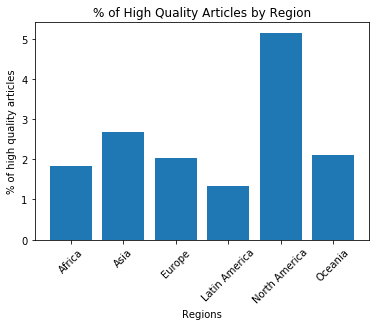

In [13]:
# makes a bar plot for high-quality articles by region
plt.bar(list(range(6)), region_data['high_quality'])
plt.xticks(list(range(6)), ['Africa', 'Asia', 'Europe', 'Latin America', 'North America', 'Oceania'], rotation=45)
plt.title('% of High Quality Articles by Region')
plt.xlabel('Regions')
plt.ylabel('% of high quality articles')
plt.savefig('high_quality_by_region.png')
plt.show()

<BarContainer object of 6 artists>

([<matplotlib.axis.XTick at 0x7fb8e5cdea20>,
 <a list of 6 Text xticklabel objects>)

Text(0.5, 1.0, 'Coverage % by Region')

Text(0.5, 0, 'Regions')

Text(0, 0.5, 'Coverage %')

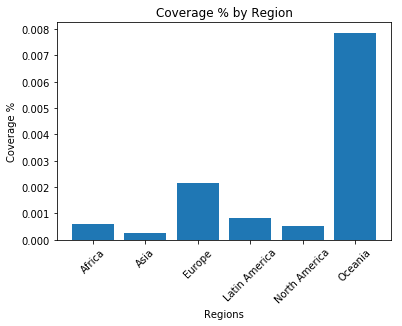

In [14]:
# makes a bar plot for coverage articles by region
plt.bar(list(range(6)), region_data['coverage'])
plt.xticks(list(range(6)), ['Africa', 'Asia', 'Europe', 'Latin America', 'North America', 'Oceania'], rotation=45)
plt.title('Coverage % by Region')
plt.xlabel('Regions')
plt.ylabel('Coverage %')
plt.savefig('coverage_by_region.png')
plt.show()


In [22]:
# Saves country and region data as .csv files.
country_data.to_csv('wp_by_country.csv')
region_data.to_csv('wp_by_region.csv')

### Results

#### Top 10 countries by coverage 
##### "10 highest-ranked countries in terms of number of politician articles as a proportion of country population."

In [23]:
# Creates table for the top 10 countries by coverage.
country_data.sort_values(by='coverage', ascending=False).head(10)[['country', 'coverage']].style.hide_index()

country,coverage
Tuvalu,0.54
Nauru,0.52
San Marino,0.27
Monaco,0.1
Liechtenstein,0.07
Tonga,0.063
Marshall Islands,0.0616667
Iceland,0.05025
Andorra,0.0425
Grenada,0.036


#### Bottom 10 countries by coverage
##### "10 lowest-ranked countries in terms of number of politician articles as a proportion of country population."

In [24]:
# Creates table for the bottom 10 countries by coverage.
country_data.sort_values(by='coverage', ascending=True).head(10)[['country', 'coverage']].style.hide_index()

country,coverage
India,7.1465e-05
Indonesia,7.91855e-05
China,8.10733e-05
Uzbekistan,8.51064e-05
Ethiopia,9.39535e-05
"Korea, North",0.000140625
Zambia,0.000141243
Thailand,0.000169184
Mozambique,0.000190164
Bangladesh,0.000191707


#### Top 10 countries by relative quality
##### "10 highest-ranked countries in terms of the relative proportion of politician articles that are of GA and FA-quality."

In [25]:
# Creates the table for the top 10 countries by relative quality.
country_data.sort_values(by='high_quality', ascending=False).head(10)[['country', 'high_quality']].style.hide_index()

country,high_quality
"Korea, North",19.4444
Saudi Arabia,12.7119
Mauritania,12.5
Central African Republic,12.1212
Romania,11.3703
Tuvalu,9.25926
Bhutan,9.09091
Dominica,8.33333
Syria,7.8125
Benin,7.69231


In [26]:
# Checks for row pertaining North Korea for curiosity.
country_data[country_data['country'] == 'Korea, North']

,country,num_article,population,coverage,B,C,FA,GA,Start,Stub,high_quality,region
82,"Korea, North",36,25600000.0,0.000141,3.0,10.0,2.0,5.0,14.0,2.0,19.444444,ASIA


#### Bottom 10 countries by relative quality
##### "10 lowest-ranked countries in terms of the relative proportion of politician articles that are of GA and FA-quality."

In [27]:
# Creates table for the bottom 10 countries by relative quality.
country_data.sort_values(by='high_quality', ascending=True)[['country', 'high_quality']].head(10).style.hide_index()

country,high_quality
Slovakia,0
Namibia,0
Cape Verde,0
Mozambique,0
Costa Rica,0
Monaco,0
Djibouti,0
Moldova,0
Uganda,0
Eritrea,0


In [28]:
print("There are {0} countries with 0 GA or FA-quality articles.".format(sum(country_data['high_quality'] == 0)))

There are 38 countries with 0 GA or FA-quality articles.


This table shows the number of countries that had 0 GA or FA-quality articles by region.

In [29]:
# Creates table for number of countries with 0 high quality articles by region.
country_data[country_data['high_quality'] == 0][['country', 'region']].groupby('region').count()

,country
region,
AFRICA,14
ASIA,2
EUROPE,10
LATIN AMERICA AND THE CARIBBEAN,6
OCEANIA,6


The offending countries are:

In [30]:
# Lists the countries with 0 high quality articles.
zero_high_quality = country_data[country_data['high_quality'] == 0]['country']
zero_high_quality

3                             Andorra
4                              Angola
5                 Antigua and Barbuda
11                            Bahamas
14                           Barbados
17                             Belize
28                           Cameroon
30                         Cape Verde
36                            Comoros
38                         Costa Rica
43                           Djibouti
49                            Eritrea
50                            Estonia
52     Federated States of Micronesia
54                            Finland
65                             Guyana
79                         Kazakhstan
81                           Kiribati
90                            Lesotho
93                      Liechtenstein
96                          Macedonia
102                             Malta
103                  Marshall Islands
107                           Moldova
108                            Monaco
112                        Mozambique
114         

<BarContainer object of 38 artists>

([<matplotlib.axis.XTick at 0x7fe4b3507978>,
 <a list of 38 Text xticklabel objects>)

Text(0.5, 1.0, 'number of articles by countries with 0 high-quality articles')

Text(0.5, 0, 'Country')

Text(0, 0.5, 'Number of articles')

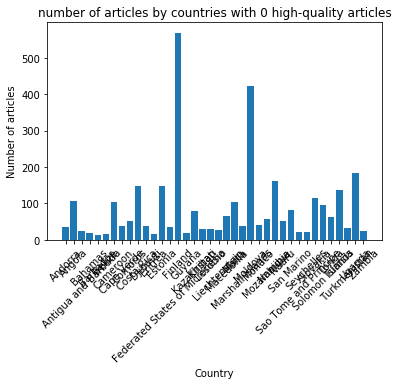

In [31]:
# Makes a bar plot for number of articles by countries with 0 high quality articles.
plt.bar(list(range(len(zero_high_quality))), country_data[country_data['high_quality'] == 0]['num_article'])
plt.xticks(list(range(len(zero_high_quality))), zero_high_quality, rotation=45)
plt.title('number of articles by countries with 0 high-quality articles')
plt.xlabel('Country')
plt.ylabel('Number of articles')
plt.show()

In [32]:
# This table shows the coverage in countries with 0 high quality articles, per region.
zero_hq_data = country_data[country_data['high_quality'] == 0]
zero_hq_by_region = zero_hq_data.groupby('region').sum()
zero_hq_by_region['coverage'] = zero_hq_by_region['num_article'] / zero_hq_by_region['population'] * 100
zero_hq_by_region[['coverage']]

,coverage
region,
AFRICA,0.000570
ASIA,0.000453
EUROPE,0.008697
LATIN AMERICA AND THE CARIBBEAN,0.003443
OCEANIA,0.029439


We can see that coverage is extremely low in countries with 0 high-quality articles, meaning that the population has little information about politicians in their country, and what little information they have is not high quality.

#### Top 10 countries by coverage with 0 high quality articles
##### "10 highest-ranked countries in terms of number of politician articles as a proportion of country population in countries with 0 high quality articles."

In [34]:
# Creates table for the top 10 countries with 0 high quality articles by coverage.
zero_hq_data.sort_values(by='coverage', ascending=False).head(10)[['country', 'coverage']].style.hide_index()

country,coverage
Nauru,0.52
San Marino,0.27
Monaco,0.1
Liechtenstein,0.07
Tonga,0.063
Marshall Islands,0.0616667
Andorra,0.0425
Federated States of Micronesia,0.036
Kiribati,0.03
Antigua and Barbuda,0.024


I find the table above particularly interesting because these are the countries with the most misinformation. 

#### Bottom 10 countries by coverage with 0 high quality articles
##### "10 lowest-ranked countries in terms of number of politician articles as a proportion of country population with 0 high quality articles."

In [35]:
# Creates table for the bottom 10 countries with 0 high quality articles by coverage.
zero_hq_data.sort_values(by='coverage', ascending=True).head(10)[['country', 'coverage']].style.hide_index()

country,coverage
Zambia,0.000141243
Mozambique,0.000190164
Eritrea,0.000266667
Angola,0.000348684
Cameroon,0.000402344
Uganda,0.000419501
Kazakhstan,0.000423913
Turkmenistan,0.000542373
Tunisia,0.00118966
Lesotho,0.00126087


The table above is also interesting because this would show the countries with least, most of them being from Africa or third-world countries in Asia.

For those countries that have at least one FA or GA-quality articles, these are the 10 lowest ranked.

In [36]:
# Creates table for bottom 10 countries with at least 1 high quality article by relative quality.
(country_data[country_data['high_quality'] != 0]).sort_values(by='high_quality', ascending=True)[['country', 'high_quality']].head(10).style.hide_index()

country,high_quality
Belgium,0.192308
Tanzania,0.246914
Switzerland,0.248756
Nepal,0.280112
Peru,0.285714
Nigeria,0.295421
Colombia,0.350877
Lithuania,0.409836
Fiji,0.507614
Azerbaijan,0.558659


In [37]:
# Checks on the row pertaining Belgium.
country_data[country_data['country'] == 'Belgium']

,country,num_article,population,coverage,B,C,FA,GA,Start,Stub,high_quality,region
16,Belgium,520,11400000.0,0.004561,6.0,24.0,0.0,1.0,171.0,318.0,0.192308,EUROPE


#### Geographic regions by coverage
##### "Ranking of geographic regions (in descending order) in terms of the total count of politician articles from countries in each region as a proportion of total regional population."

In [38]:
# Creates table for the regions by coverage.
region_data.sort_values(by='coverage', ascending=False)[['region', 'coverage']].style.hide_index()

region,coverage
OCEANIA,0.00786325
EUROPE,0.00215957
LATIN AMERICA AND THE CARIBBEAN,0.000822735
AFRICA,0.000584357
NORTHERN AMERICA,0.000526013
ASIA,0.000255501


#### Geographic regions by relative quality
##### "Ranking of geographic regions (in descending order) in terms of the relative proportion of politician articles from countries in each region that are of GA and FA-quality."

In [39]:
# Creates table for the regions by relative quality.
region_data.sort_values(by='high_quality', ascending=False)[['region', 'high_quality']].style.hide_index()

region,high_quality
NORTHERN AMERICA,5.15357
ASIA,2.68841
OCEANIA,2.10997
EUROPE,2.02975
AFRICA,1.82455
LATIN AMERICA AND THE CARIBBEAN,1.33488


### Reflections

Before starting to work on the data, I expected articles from developing countries, and non-democratic countries to receive a high amount of low scores in the predictions. This is because I suspected that articles from developing countries would be less regulated, partly due to the population's inability to access the internet. In addition, countries like China and North Korea could censor or edit articles in order to promote their political agendas. One example of how my preconceptions were challenged is the fact that North Korea is ranked first in the list of top 10 countries with high-quality articles. It could be explained by the fact that there are a few number of articles related to North Korea, or that other entities or organizations took it upon themselves to write the articles, since it cannot be expected for residents in North Korea to write or edit articles on the English Wikipedia website.

The results suggest that Wikipedia is not that really as a data source when it comes to political articles. This might be because anyone can edit Wikipedia, and there could be several political parties trying to improve their standing on the internet by editing Wikipedia articles. While we assume that the data of the classifications made by people is correct, there is a chance that they could also introduce bias in the predictive model by classifying an article they do not agree with as a low quality article. And lastly, further testing should be done regarding the quality of Wikipedia articles by choosing a different subject, such as science, where the information is more factual. While it was disheartening to see that Wikipedia has a low percentage of high quality articles, the fact that low value is present in articles related to every country and region gives us a warning to always be on the lookout for bias since, as the results show, is everywhere.

For further work, it would be interesting to use another classifier built by different people to see if the predictions are accurate, and if not, could the bias be in the classification of the articles during the training phase? It would also be interesting if the datasets had more features, such as the political teams for each country and for each article and the percentage of their representation in the government. Looking into the correlation between coverage and the percentage of high-quality articles also seems like a promising path for future work.


Table subtitles obtained from: https://wiki.communitydata.science/Human_Centered_Data_Science_(Fall_2019)/Assignments#A2:_Bias_in_data